In [2]:
import pandas as pd
from ast import literal_eval
from decimal import Decimal
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Loader():
    def strToDecArr(self, str):
        # this version is slower and potentially insecure because of the eval function
        # return np.array([eval(x) for x in str[1:-1].split(', ')])
        return np.asarray([Decimal(x.split("'")[1]) for x in str[1:-1].split(', ')])

    def load_snapshots(self, filepath):
        return pd.read_csv(filepath,
                           converters={"ask_prices": self.strToDecArr, "ask_amounts": self.strToDecArr,
                                       "bid_prices": self.strToDecArr, "bid_amounts": self.strToDecArr,
                                       "date": pd.to_datetime})

    def load_trades(self, filepath):
        return pd.read_csv(filepath, converters={"date": pd.to_datetime})

In [4]:
loader = Loader()

snapshots = loader.load_snapshots(
    "/Users/Fanda/Documents/TUM_Offline/HF_Data-15.10.2021/snapshots_btc-usdt_20211015.csv")
trades = loader.load_trades(
    "/Users/Fanda/Documents/TUM_Offline/HF_Data-15.10.2021/trades_btc-usdt_20211015.csv")

In [5]:
snapshots["midprice"] = snapshots.apply(lambda x: (np.min(x.loc["ask_prices"]) + np.max(x.loc["bid_prices"])) / 2,
                                        axis=1)

In [6]:
def orderbook_imbalance(x):
    total_bid_volume = np.sum(x.loc["bid_amounts"])
    total_ask_volume = np.sum(x.loc["ask_amounts"])
    return ((total_bid_volume - total_ask_volume) / (total_bid_volume + total_ask_volume))


snapshots["orderbook_imbalance"] = snapshots.apply(orderbook_imbalance, axis=1)

In [7]:
minute_snapshots = snapshots.resample('min', on='date').agg({'midprice':'mean', 'orderbook_imbalance':'mean'})

In [8]:
def agg(x):
    names = {
        'open': x['price'].head(1).item(),
        'high':  x['price'].max(),
        'low': x['price'].min(),
        'close':  x['price'].tail(1).item(),
        'volume_base': x['amount'].sum(),
        'volume_quote': (x['amount'] * x['price']).sum()}

    return pd.Series(names)


minute_trades = trades.resample('min', on='date').apply(agg)

In [9]:
close_rolling = minute_trades["close"].rolling(60).mean()
orderbook_imbalance_rolling = minute_snapshots["orderbook_imbalance"].rolling(
    60).mean()

<AxesSubplot:xlabel='date'>

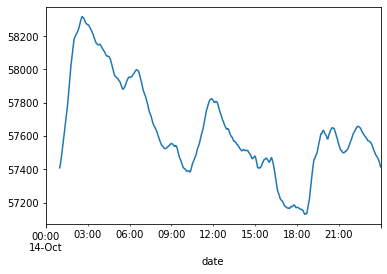

In [10]:
close_rolling.plot()

<AxesSubplot:xlabel='date'>

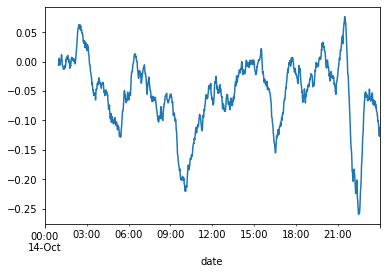

In [11]:
orderbook_imbalance_rolling.plot()

We can observe that most of the time there is a sell order imbalance - which means that there are more sell orders in volume than buy orders. The orderbook imbalance graph correlates with the close price graph. We can observe that when the price was going up people were more buying when it was going down more selling.

In [32]:
snapshots.head(1)

,timestamp,update_id,market,depth,ask_prices,ask_amounts,bid_prices,bid_amounts,date,midprice,orderbook_imbalance
0,1634169600034644741,14311550913,btc-usdt,20,"[57367.01, 57370.82, 57370.84, 57370.85, 57372...","[0.00909, 0.04631, 0.00146, 0.13074, 0.06798, ...","[57367, 57366.99, 57366.98, 57362.24, 57361.24...","[1.18061, 1.93, 0.64, 0.22, 0.2, 0.00591, 0.22...",2021-10-14 00:00:00.034645,57367.005,0.2613955343211463483570220032


In [ ]:
# I am assuming that ask and bid prices have correct ordering (= first value closest to midprice)
def get_weighted_price(volume, offer):
    total_price = Decimal(0)
    total_amount = Decimal(0)
    price, amount = offer
    for price, amount in zip(price, amount):
        if volume > (price * amount):
            volume -= price * amount
            total_price += price * amount
            total_amount += amount
        else:
            needed_amount = volume / price
            total_price += price * needed_amount
            total_amount += needed_amount
            volume = 0
            break
    if volume == 0:
        return total_price / total_amount
    else:
        # Order of this volume is not possible to fulfil
        return Decimal('NaN')


volumes = [1000, 10000, 50000, 100000, 1000000]
for volume in volumes:
    ask_offers = zip(snapshots["ask_prices"], snapshots["ask_amounts"])
    snapshots[f"buy_impacts_{volume}"] = [
        get_weighted_price(volume, offer) for offer in ask_offers]

for volume in volumes:
    bid_offers = zip(snapshots["bid_prices"], snapshots["bid_amounts"])
    snapshots[f"sell_impacts_{volume}"] = [
        get_weighted_price(volume, offer) for offer in bid_offers]

In [68]:
buy_impacts = np.empty(len(volumes))
sell_impacts = np.empty(len(volumes))
for i, volume in enumerate(volumes):
    buy_impacts[i] = snapshots.apply(lambda x: abs(x["midprice"] - x[f"buy_impacts_{volume}"]) / x["midprice"] * 100, axis = 1).mean()
    sell_impacts[i] = snapshots.apply(lambda x: abs(x["midprice"] - x[f"sell_impacts_{volume}"]) / x["midprice"] * 100, axis = 1).mean()

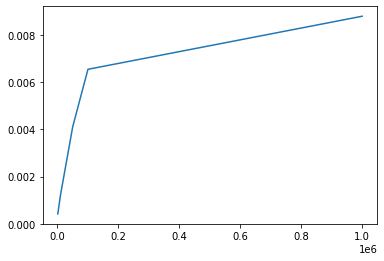

In [70]:
plt.plot(volumes, buy_impacts)

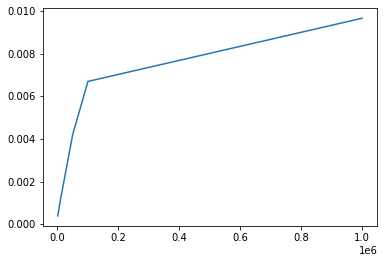

In [71]:
plt.plot(volumes, sell_impacts)

We can see that the impact is rising with bigger amounts. This is logical since trades for bigger volumes consist of multiple orders. Those trades can only include orders the same or more distant from the ideal price and therefore have higher impact cost.